# Lab 6: Convolutional Network Architectures
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Imagine life in Florence, Italy in the early 1500s. The Renaissance was at its peak, the Catholic Church was abusing its power, and the plebians cried themselves to sleep every night knowing they [probably wouldn't live past 40](https://www.verywellhealth.com/longevity-throughout-history-2224054). And then there was Leonardo da Vinci, who decided [to create a self-propelled car "for theatrical use"](https://www.da-vinci-inventions.com/self-propelled-cart). While da Vinci was ahead of his time, his work would later inspire others to create the first self-driving car.

Our dataset, titled "Vehicle Detection Image Set", is a dataset of 64x64 images, with each image being classified as either <code>vehicle</code> or <code>non-vehicle</code>. Our task is to create a Convolutional Neural Network that can classify images as being either <code>vehicle</code> or <code>non-vehicle</code>.

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 1. Preparation
### 1.1 Performance Metric

We'll start by reading in the data from our vehicle detection Kaggle dataset.

There are 17760 images


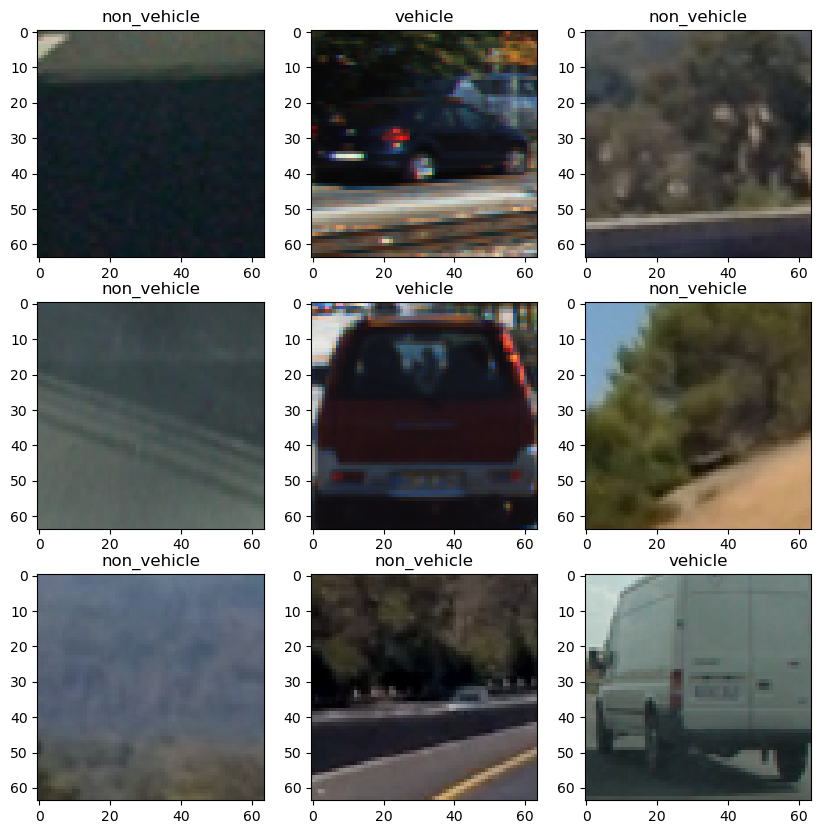

In [1]:
import glob
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.simplefilter('ignore')

# load in images and labels as numpy arrays
images_and_labels = []

for filename in glob.glob('data/vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'vehicle')))
    

for filename in glob.glob('data/non-vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'non_vehicle')))
    

print('There are', len(images_and_labels), 'images')

# plot some images
plt.figure(figsize = (10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].astype('uint8'))
    plt.title(images_and_labels[index][1])

It's important to note that these images seem to have been sourced by splitting an image, taken from a car driving on a road, into multiple sub-images that are all 64x64 pixels (as shown in the example images above). This is relevant, as it means all images in this dataset are things a car could realistically see while driving.

Now that we've read in the images, let's visualize the distribution of labels for our images.

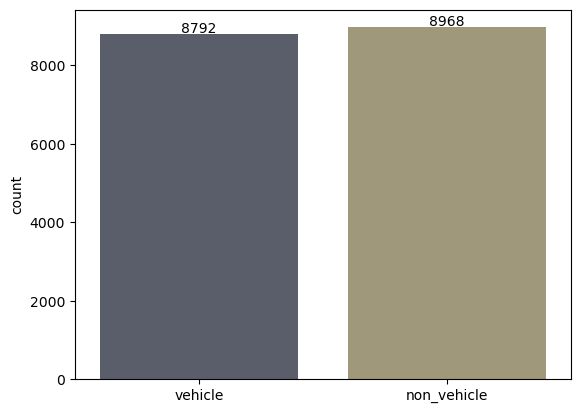

In [2]:
import seaborn as sns

ax = sns.countplot(x=[label for _, label in images_and_labels], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['vehicle', 'non_vehicle'])
plt.show()

As we can see, there are about the same number of instances for each label (<code>non_vehicle</code> has a little less than 200 more instances than <code>vehicle</code>). Because the number of images in both of our classes are so similar, there will be negligible effects from class imbalance. Thus, we will utilize **accuracy** as our evaluation metric.

Despite accuracy being flawed in many situations, it actually fits our needs for this dataset. In balanced datasets, accuracy favors all classes equally, which in our case is needed, as we would want our self-driving cars to avoid both other vehicles as well as other road hazards. Accuracy also cares about all errors equally, which is needed, as swerving to avoid a car that is not there (false positives) and colliding with cars the system did not detect (false negatives) are both undesirable outcomes. Finally, as we noted earlier, all of the images in this dataset come from actual image data captured by cars driving on roads; thus, all of the image data is relevant, and we want our model to be able to distinguish between vehicles and anything else it may see while driving on a road.

For these reasons, we will use accuracy to determine the performance of our neural networks. Because of our business case, we believe our prediction models would need to be more than 99% accurate to be considered usable in a real world self-driving car (as incorrect predictions could potentially result in loss of human life).

### 1.2 Training and Testing Method
Now we'll split our dataset into training and testing splits. We'll be using a random sample of 3000 images in the dataset to train and test our models on (as, quite frankly, using the whole dataset takes far too long on our measly laptops).

In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import random

# take a 3000 image subset
images_and_labels = random.sample(images_and_labels, 3000)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

X = np.array([image for image, _ in images_and_labels])
y = np.array([0 if label == 'vehicle' else 1 for _, label in images_and_labels])

# normalize pixel values and mean shift
X = X/255.0 - 0.5

mean_fpr = np.linspace(0, 1, 100)

def get_accuracy(X, y, new_model):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    accuracies = []
    mean_tpr_list = []
    auc_list = []

    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index, :, :, :], X[test_index, :, :, :]
        y_train, y_test = y[train_index], y[test_index]

        history = new_model.fit(X_train, y_train, batch_size=64,
                                epochs=5, verbose=0,
                                validation_data=(X_test,y_test),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

        print(f"Fold {i}")
        i += 1
        
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='training')

        plt.ylabel('Accuracy %')
        plt.title('Training')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='training')
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        plt.plot(history.history['val_loss'], label='validation')
        plt.xlabel('epochs')
        plt.title('Loss')
        plt.legend()
        plt.show()

        accuracies.append(history.history['val_accuracy'][-1])
        
        yhat = np.round(new_model.predict(X_test, verbose=0))
        
        fpr, tpr, thresholds = roc_curve(y_test, yhat)
        mean_tpr_list.append(np.interp(mean_fpr, fpr, tpr))
        auc_list.append(auc(fpr, tpr))

    plt.bar(range(len(accuracies)), accuracies)
    plt.ylim([min(accuracies) - 0.01, max(accuracies)])
    plt.title('Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    print("Average Accuracy:", np.mean(accuracies))
    
    return accuracies, mean_tpr_list, auc_list


As seen above, we decided to use KFold cross validation with 5 splits. Since there isn't really a class imbalance, there is no need to stratify the data. We decided to use 5 splits as this allows for an 80/20 train test split (where our model trains on 80% of the data and uses the other 20% as validation data). We believe this is appropriate, as we have plenty of data to work with, and the 80/20 train test split is a common practice in machine learning. We also normalize the pixel values and shift the mean to be zero, removing as much noise as possible for the models.

This cross validation method is a realistic mirroring of how an algorithm would be used in practice, as a prediction model being used by self-driving cars would need to be trained on a lot of data. KFold allows us to train the models on several distinct groups of data, which is important to ensure the validity of the results. Additionally, with access to so much data, there is no need to use ShuffleSplit (in which data can be reused across folds). It is important to note, however, that an actual model being used by a self-driving car would likely need to be trained on a lot more data (probably millions of different images). Nevertheless, with the data and computational resources we have, we believe this is a realistic mirroring of how a model would be trained in practice.

## 2. Modeling
### 2.1 Data Augmentation
Now that we've defined our performance metric and created training and testing splits for cross validation, let's start creating our Convolutional Neural Networks! Let's start by creating a base for our models that includes some data augmentation layers.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness

model_base = Sequential()

model_base.add(RandomFlip("horizontal"))
model_base.add(RandomRotation(0.2))
model_base.add(RandomZoom((-0.1, 0.1)))
model_base.add(RandomBrightness(0.2))

For our Convolutional Neural Networks, we decided to use the following data augmentation layers:
- <code>RandomFlip("horizontal")</code>: This layer will randomly flip some of the images horizontally (i.e., what's on the left side of the image would now be on the right side of the image). This is appropriate, as self-driving cars would likely encounter vehicles and non-vehicles with different horizontal alignments (such as cars angled slightly right OR slightly left, roads angled slightly right OR slightly left, etc.).
- <code>RandomRotation(0.2)</code>: This layer will randomly rotate an image by up to 20%. This is appropriate, as self-driving cars would likely encounter vehicles and non-vehicles with different orientations (such as cars angled slightly right/left/up/down (for curves in the road or going up hills), roads angled slightly right/left/up/down, etc.).
- <code>RandomZoom((-0.1, 0.1))</code>: This layer will randomly zoom in/out on an image by up to 10%. This is appropriate, as self-driving cars would encounter vehicles and non-vehicles at different distances (such as being close to some vehicles and far from others, close to some trees on the side of the road and far from others, etc.).
- <code>RandomBrightness(0.2)</code>: This layer will randomly increase/decrease the brightness of an image by up to 20%. This is appropriate, as self-driving cars would encounter vehicles and non-vehicles at different times of day with differing amounts of light (such as driving when it's dark very late at night or driving in the afternoon when there is a lot of sunlight).

We chose these augmentation layers because we believe that these slight rotations, zooms, and brightness changes will simulate what a self-driving car is going to see on the roads. We did not include vertical flips, and large augmentations as these will not be useful for our model to learn as they likely do not appear in the real world.

### 2.2 Model Creation
Now let's create a few different models using the base structure we just created.

#### 2.2.1 CNN 1: Basic Network
To start, let's make a Convolutional Neural Network inspired by AlexNet to see how it performs on our data.

Fold 1


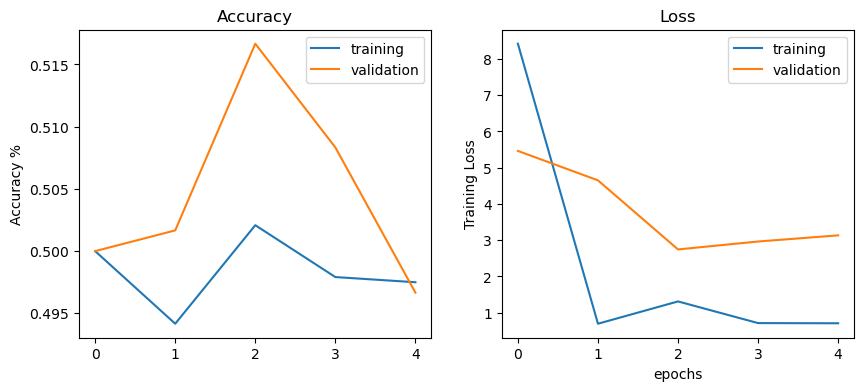

Fold 2


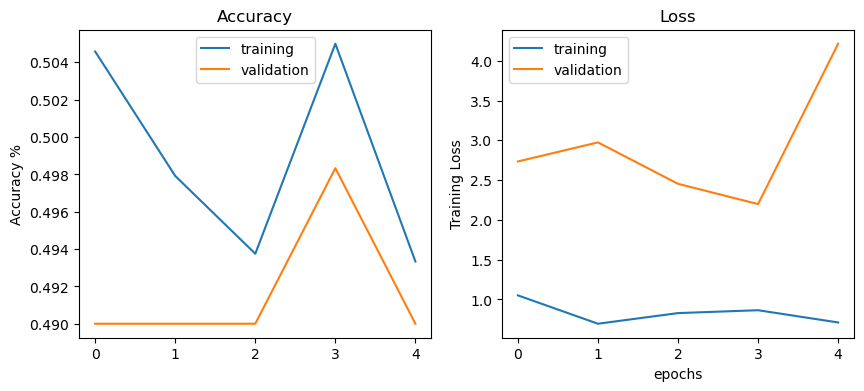

Fold 3


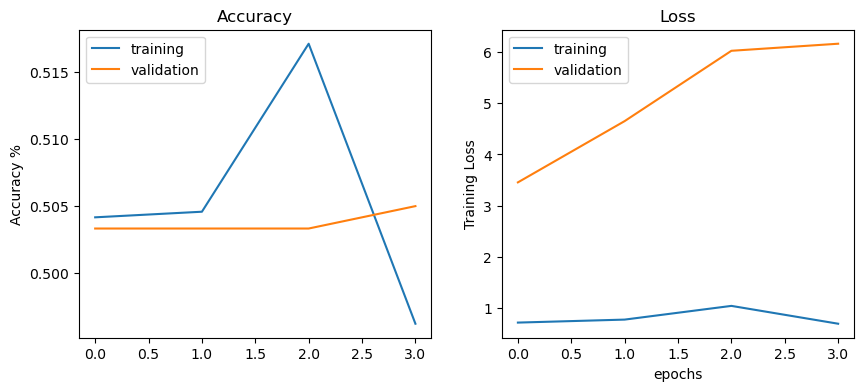

Fold 4


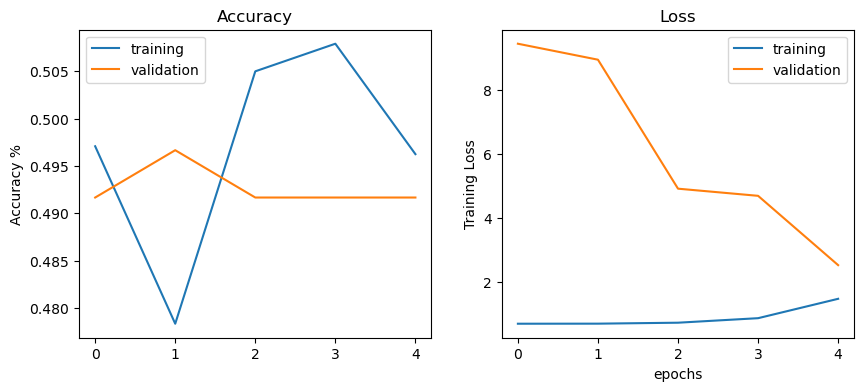

Fold 5


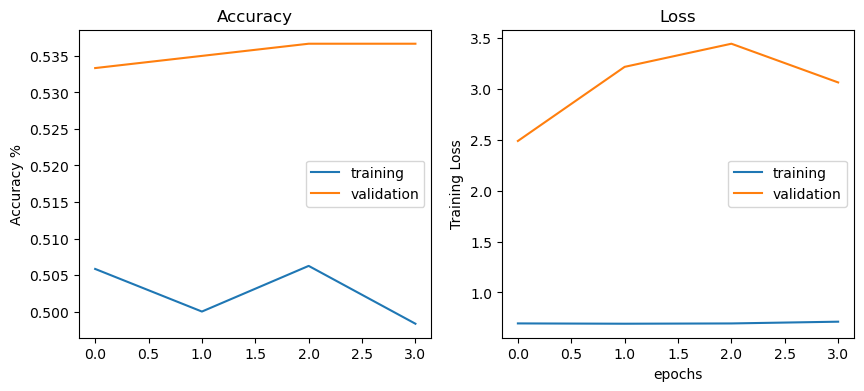

Average Accuracy: 0.5040000081062317


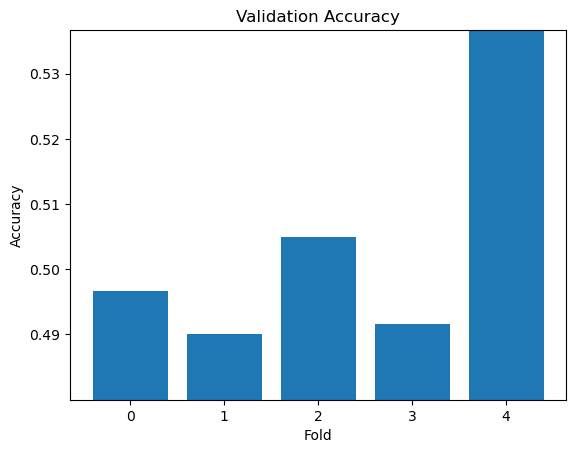

In [5]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import logging

# clears Tensorflow warnings
tf.get_logger().setLevel(logging.ERROR)

cnn_1 = clone_model(model_base)

# The following CNN was heavily inspired by Dr. Larson's Notebook (12. More Advanced CNN Techniques)
NUM_CLASSES = 2
img_wh = 64

# let's start with an AlexNet style convolutional phase
cnn_1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn_1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_1.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn_1.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

accuracies_basic, mean_tpr_list_basic, auc_list_basic = get_accuracy(X, y, cnn_1)

As seen above, our first Convolutional Neural Network isn't very good; in fact, it's accuracy is roughly 50% (meaning it's just as accurate as random guessing would be). Furthermore, there is a pretty high variance in validaction accuracy across the 5 folds, which frankly is not ideal.

We can also see that the model doesn't seem to be converging (as the loss graphs don't have negative slopes), and some of the folds have a higher validation accuracy than training accuracy (which isn't necessarily wrong, but it doesn't seem ideal either). Thus, we can conclude that this type of CNN architecture is not ideal for our prediction task.

#### 2.2.2 CNN 2: Ensemble Network

Since our last model wasn't very good, let's try something completely new. We'll construct an Ensemble Network to try to improve our model’s accuracy. Ensemble Networks run multiple models and use the results from each one to increase performance and reduce overfitting. We also added max pooling to this model to take advantage of dimensionality reduction and down sampling to make the model faster while also disregarding redundant or not important features. This model also uses flattening and dropout like our previous model.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_16[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 32)  0           ['conv2d_17[0][0]']              
                                                                                            

Total params: 896,045
Trainable params: 896,045
Non-trainable params: 0
__________________________________________________________________________________________________
Fold 1


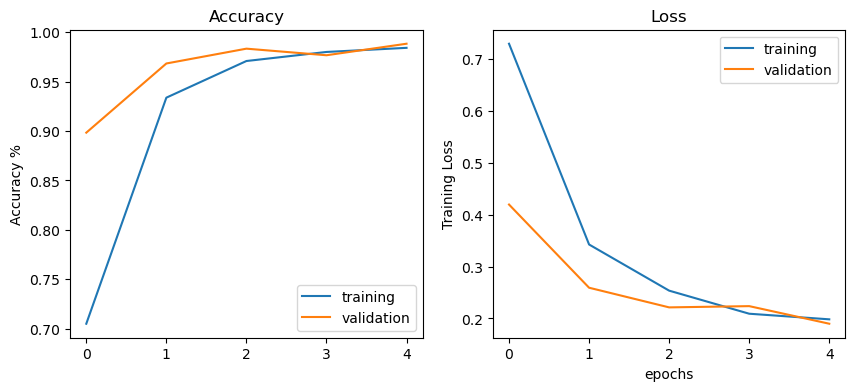

Fold 2


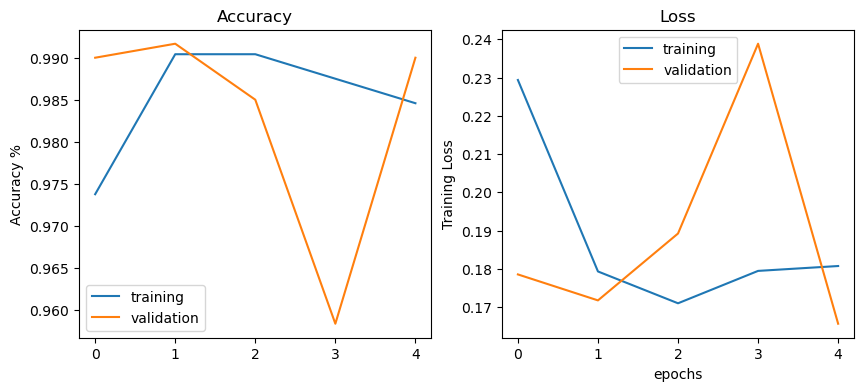

Fold 3


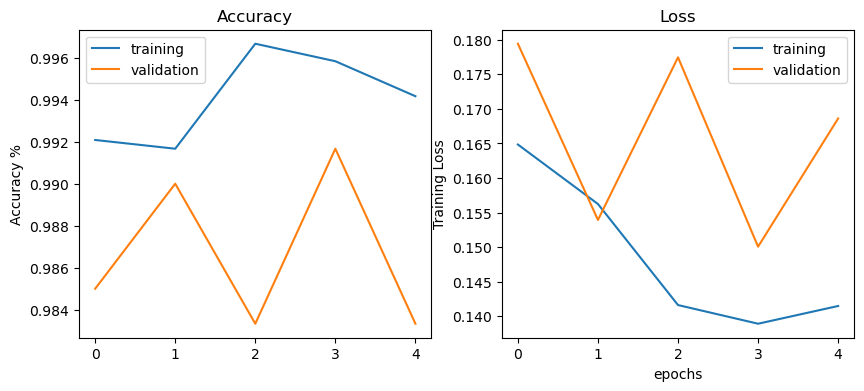

Fold 4


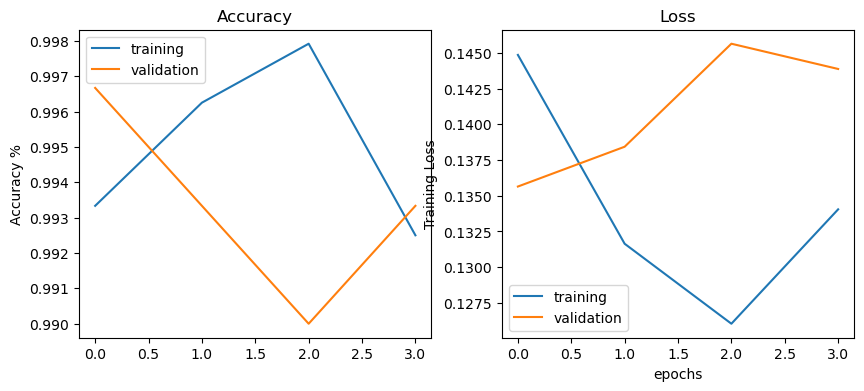

Fold 5


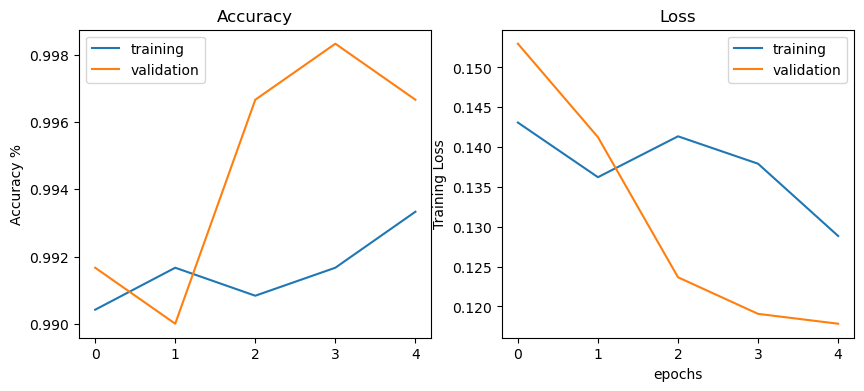

Average Accuracy: 0.9903333425521851
CPU times: total: 54min 47s
Wall time: 4min 56s


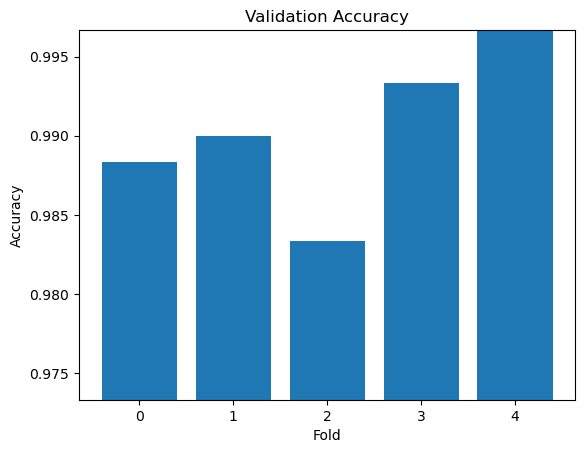

In [7]:
%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

num_ensembles = 3
l2_lambda = 0.0001

input_holder = Input(shape=(img_wh,img_wh,3))


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens = clone_model(model_base)
cnn_ens = Model(inputs=input_holder, outputs=x)
cnn_ens.summary()

cnn_ens.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam',
                metrics=['accuracy'])

accuracies_ens, mean_tpr_list_ens, auc_list_ens = get_accuracy(X, y, cnn_ens)

As seen above, this model is quite frankly far superior to our first model. With an average validation accuracy of 99%, and a small variance of about 1% across all folds, this model appears to be very suitable for our prediction task. While some of the loss graphs look a little weird, the model does appear to converge; perhaps with more training epochs, the loss graphs would show a clearer convergence. Nevertheless, the Ensemble Network architecture seems to be pretty good.

#### 2.2.3 CNN 3: Modified Ensemble Network
Now let's create another Convolutional Neural Network based on this Ensemble Network's architecture with some modifications to the parameters to see if we can improve upon the accuracy. For this CNN, we'll change the number of ensembles from 3 to 4.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_58 (Conv2D)             (None, 64, 64, 32)   896         ['input_6[0][0]']                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_58[0][0]']              
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_59[0][0]']              
 )                                                                                          

                                                                                                  
 dense_28 (Dense)               (None, 64)           262208      ['dropout_15[0][0]']             
                                                                                                  
 dense_30 (Dense)               (None, 64)           262208      ['dropout_16[0][0]']             
                                                                                                  
 dense_32 (Dense)               (None, 64)           262208      ['dropout_17[0][0]']             
                                                                                                  
 dense_34 (Dense)               (None, 64)           262208      ['dropout_18[0][0]']             
                                                                                                  
 dense_29 (Dense)               (None, 2)            130         ['dense_28[0][0]']               
          

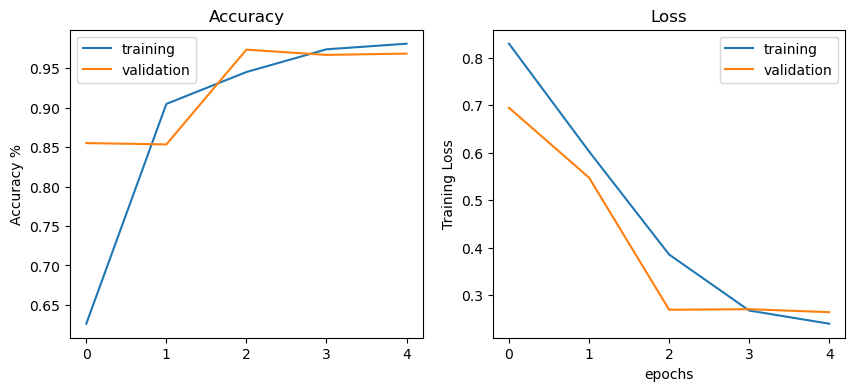

Fold 2


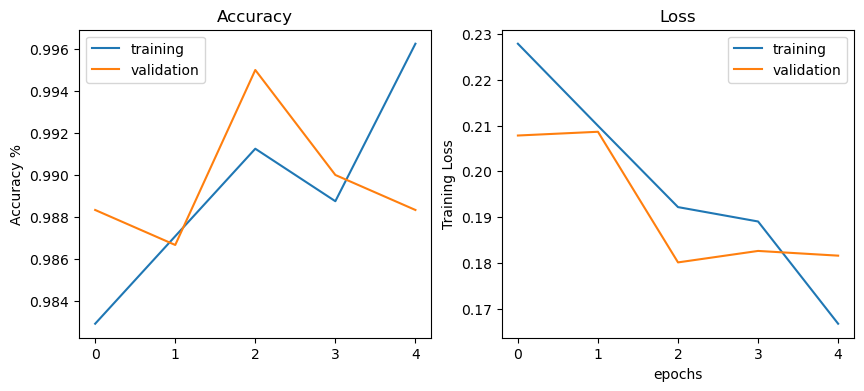

Fold 3


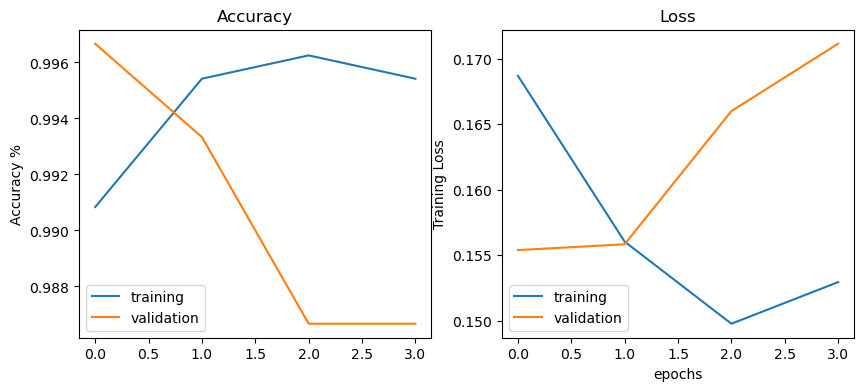

Fold 4


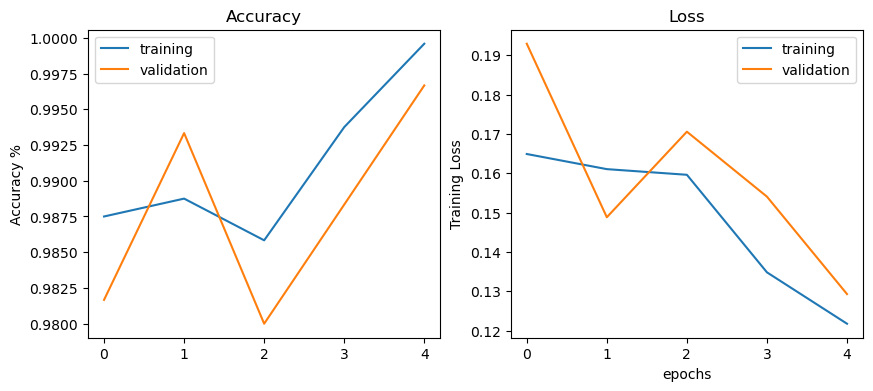

Fold 5


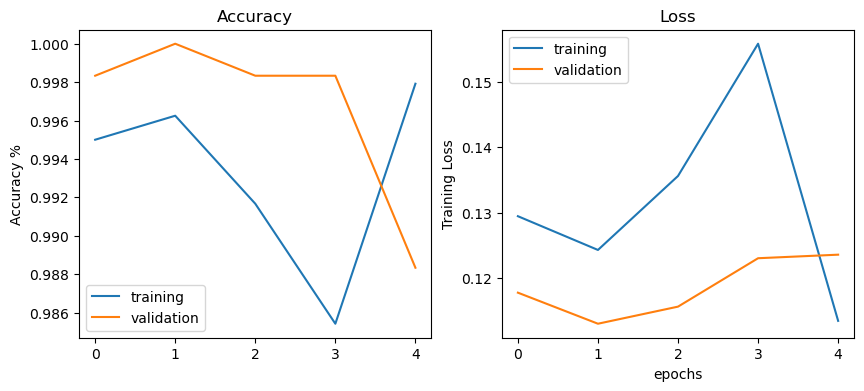

Average Accuracy: 0.9856666684150696
CPU times: total: 1h 3min 43s
Wall time: 5min 47s


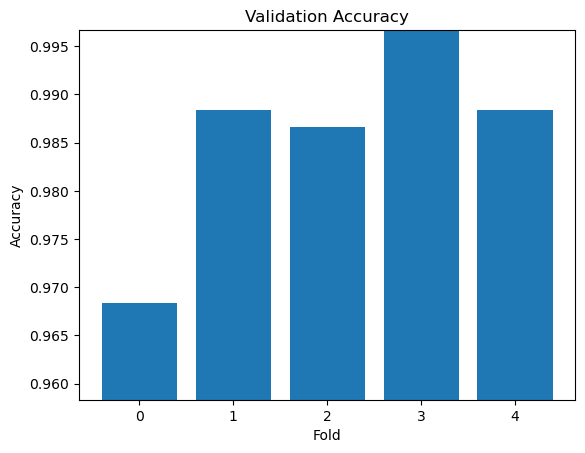

In [12]:
%%time
# MODIFIED ENSEMBLE MODEL
# Change the number of ensembles to 2

num_ensembles = 4 # was 3
l2_lambda = 0.0001

input_holder = Input(shape=(img_wh,img_wh,3))


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=((3,3)),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=((3,3)),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=((3,3)),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=((3,3)),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens_mod = clone_model(model_base)
cnn_ens_mod = Model(inputs=input_holder, outputs=x)
cnn_ens_mod.summary()

cnn_ens_mod.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

accuracies_ens_mod, mean_tpr_list_ens_mod, auc_list_ens_mod = get_accuracy(X, y, cnn_ens_mod)

As seen above, this model frankly isn't as good as the first Ensemble model. The variance across folds is worse (around 2.5%), and the average accuracy dropped to about 98.5%. Nevertheless, the model does appear to converge, and the accuracy for its predictions is respectable.

#### 2.2.4 CNN 4: ResNet
For our next few models, we'll try using the ResNet architecture. ResNets are a type of neural network that allow layers to be skipped without affect the model's performance (which could potentially increase training efficiency). It's designed to support hundreds, or even thousands, of convolutional layers, so it could potentially be well suited to our prediction task.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 64, 64, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_48[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 32, 32, 32)   9248        ['max_pooling2d_24[0][0]'] 

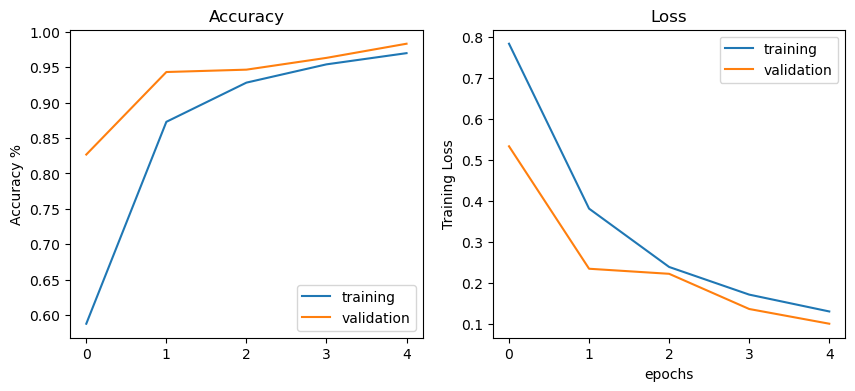

Fold 2


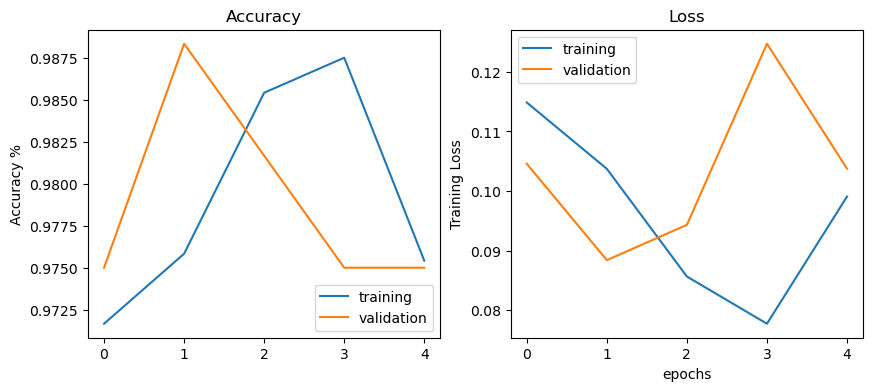

Fold 3


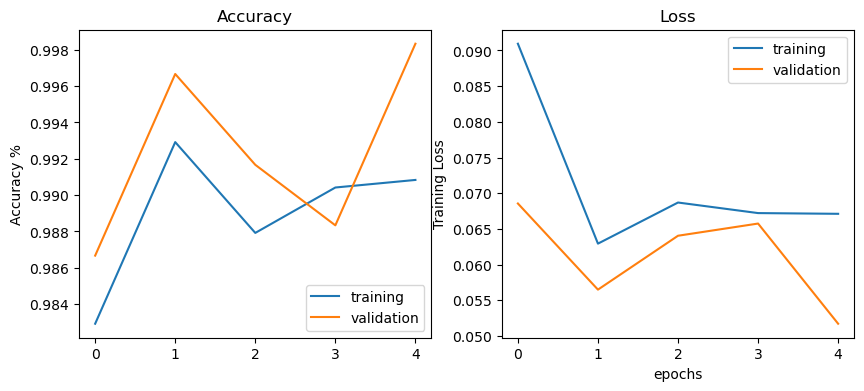

Fold 4


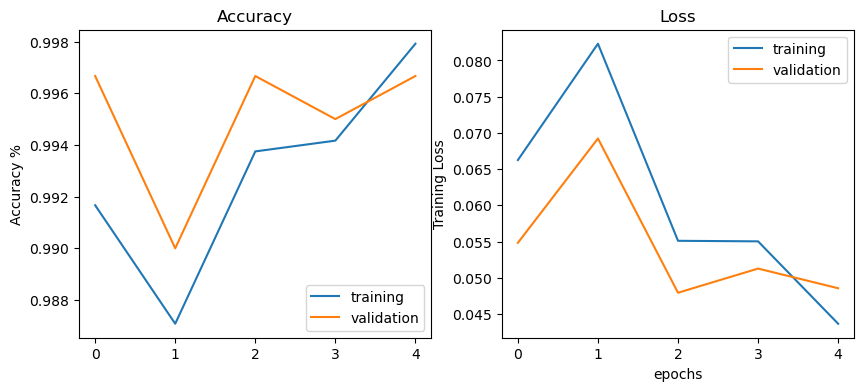

Fold 5


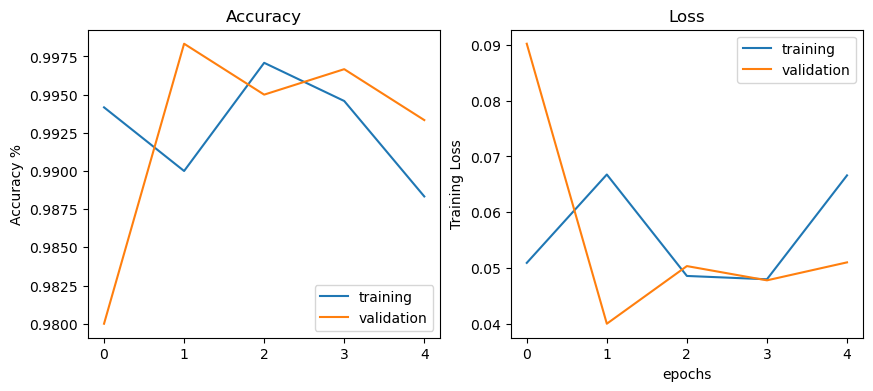

Average Accuracy: 0.9893333435058593
CPU times: total: 19min 58s
Wall time: 1min 52s


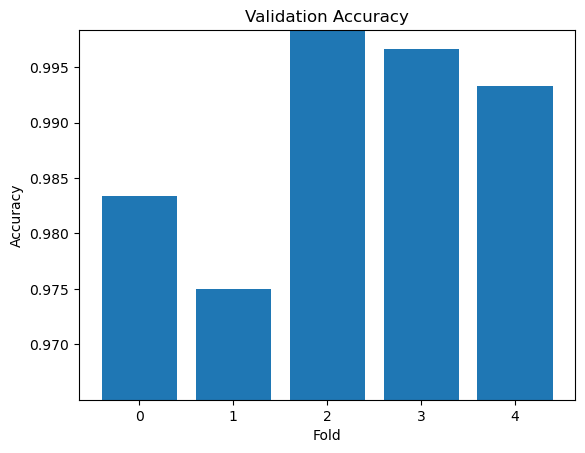

In [9]:
%%time
from tensorflow.keras.layers import Add, Activation

input_holder = Input(shape=(img_wh,img_wh,3))

# Start with a convolutional layer
x = Conv2D(filters=32, 
            input_shape = (img_wh,img_wh,3),
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=64,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x_split)

x = Conv2D(filters=64,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)
    

# Add back in the split layer, x_split
x = Add()([x, x_split])
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

resnet = clone_model(model_base)
resnet = Model(inputs=input_holder, outputs=x)
resnet.summary()

resnet.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# res_history = resnet.fit(X_train, y_train, batch_size=32,
#                         steps_per_epoch=int(len(X_train)/128), 
#                         epochs=5, verbose=0,
#                         validation_data=(X_test,y_test),
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#                         )

accuracies_res, mean_tpr_list_res, auc_list_res = get_accuracy(X, y, resnet)

As seen above, our ResNet model performed pretty well; it's accuracy (98.9%) is pretty good, and its variance in accuracy across folds is only about 2%. To be frank though, it still isn't as good as our first Ensemble network. Nevertheless, the loss graphs show that it converges.

#### 2.2.5 CNN 5: Modified ResNet
To improve our ResNet model, let's try modifying the parameters. We'll change the first Convolutional layer to have 64 filters, and we'll change both Dropout layers at the end of the network to not update 35% of the weights.

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 64, 64, 64)   1792        ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_76[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 32, 32, 32)   18464       ['max_pooling2d_39[0][0]'] 

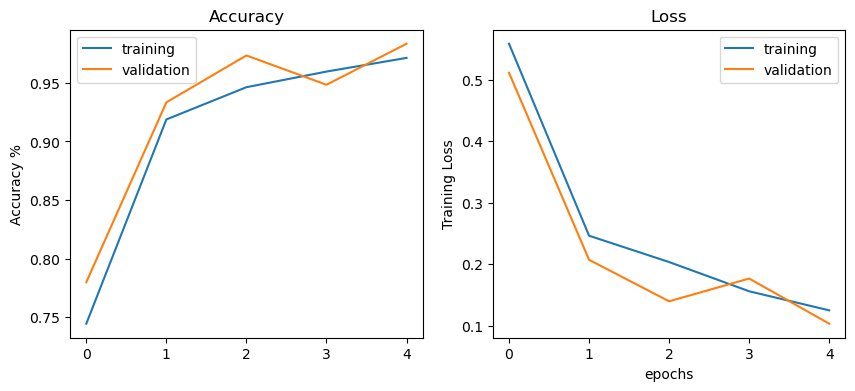

Fold 2


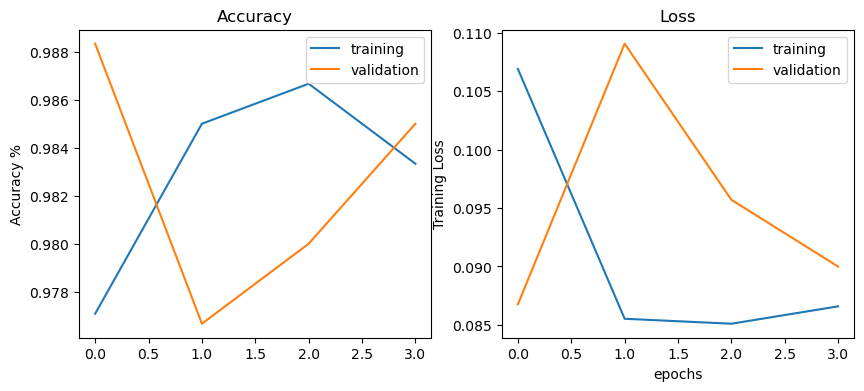

Fold 3


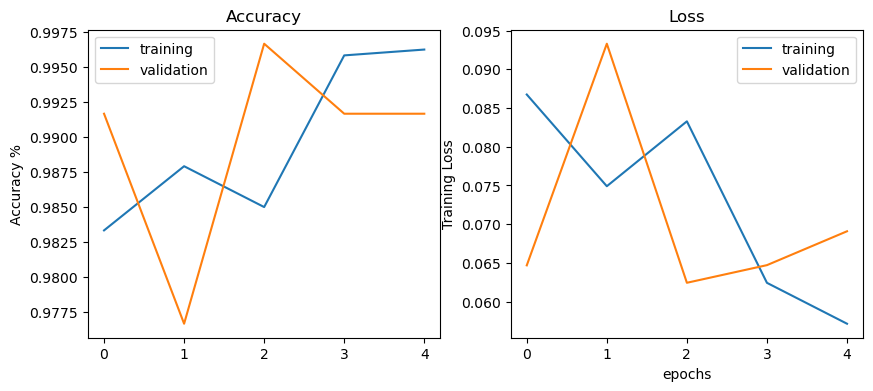

Fold 4


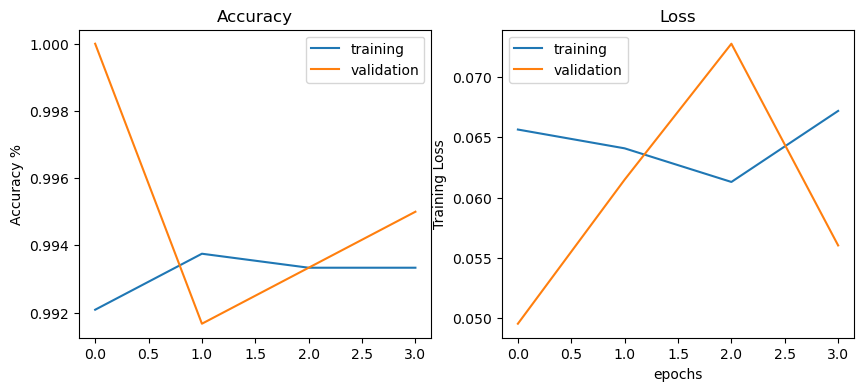

Fold 5


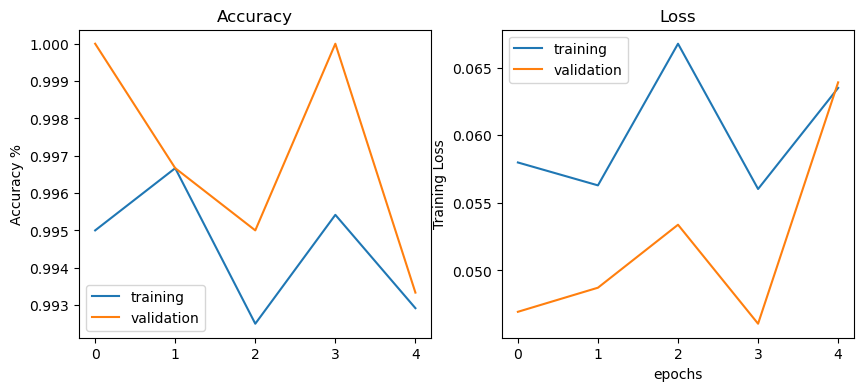

Average Accuracy: 0.9896666765213012
CPU times: total: 23min 15s
Wall time: 2min 11s


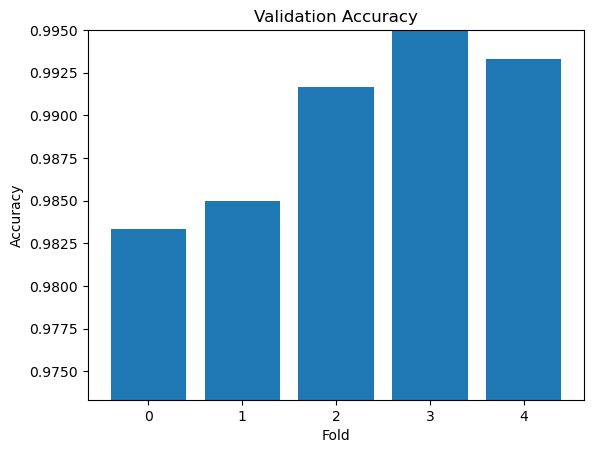

In [13]:
%%time
# MODIFIED RESNET MODEL
# Removing a dense layer and dropout layer

input_holder = Input(shape=(img_wh,img_wh,3))

# Start with a convolutional layer
x = Conv2D(filters=64, # changed number of filters from 32 to 64
            input_shape = (img_wh,img_wh,3),
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=64,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x_split)

x = Conv2D(filters=64,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)
    

# Add back in the split layer, x_split
x = Add()([x, x_split])
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.35)(x) # changed Dropout from .25 to .35
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.35)(x) # changed Dropout from .5 to .35
x = Dense(1)(x)
x = Activation('sigmoid')(x)

resnet_mod = clone_model(model_base)
resnet_mod = Model(inputs=input_holder, outputs=x)
resnet_mod.summary()

resnet_mod.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

accuracies_res_mod, mean_tpr_list_res_mod, auc_list_res_mod = get_accuracy(X, y, resnet_mod)

As seen above, we slightly improved upon the accuracy of our original ResNet model (by about .0003%). The variance across folds is also much better (around 1%). However, frankly speaking, this is still not as accurate as our first Ensemble model. Regardless, this model does appear to converge, and its accuracy is respectable.

### 2.3 Model Visualization and Comparison

Now that we have created four different CNN's based on two different architectures (not including our very first model, which we'll pretend doesn't exist), let's visualize the results of each model and compare them to each other.

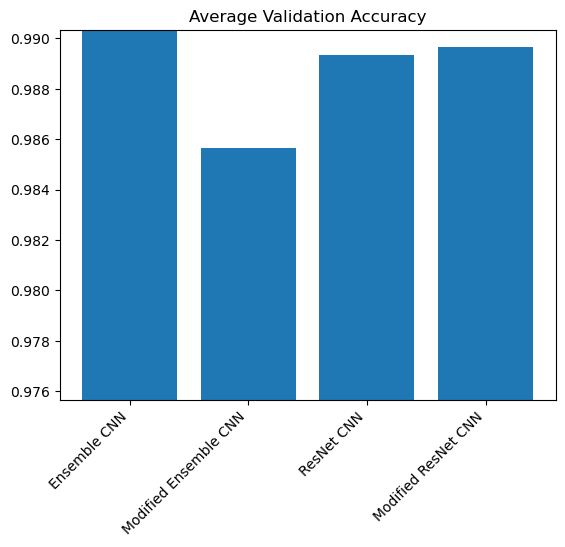

In [22]:
# # Compare the Ensembles and ResNets (include the modified versions) accuracy
# #Plot as line graph

accuracies = [np.mean(accuracies_ens), np.mean(accuracies_ens_mod), np.mean(accuracies_res), np.mean(accuracies_res_mod)]

plt.bar(['Ensemble CNN', 'Modified Ensemble CNN', 'ResNet CNN', 'Modified ResNet CNN'], accuracies)
plt.ylim([min(accuracies) - 0.01, max(accuracies)])
plt.xticks(rotation=45, ha='right')
plt.title('Average Validation Accuracy')
plt.show()

Based on the results of these models, we can see that based on accuracy alone, the original Ensemble Network appears to be the best (closely followed by our Modified ResNet CNN and original ResNet CNN). The Modified Ensemble CNN performs the worst, which suggests that our change in parameter (the number of ensembles) was not a good choice for our prediction task.

While accuracy is our performance metric for this dataset, we can also look at other forms of evaluation for these models (such as the ROC curves for each model, which we'll look at now).

(0.8, 1.0)

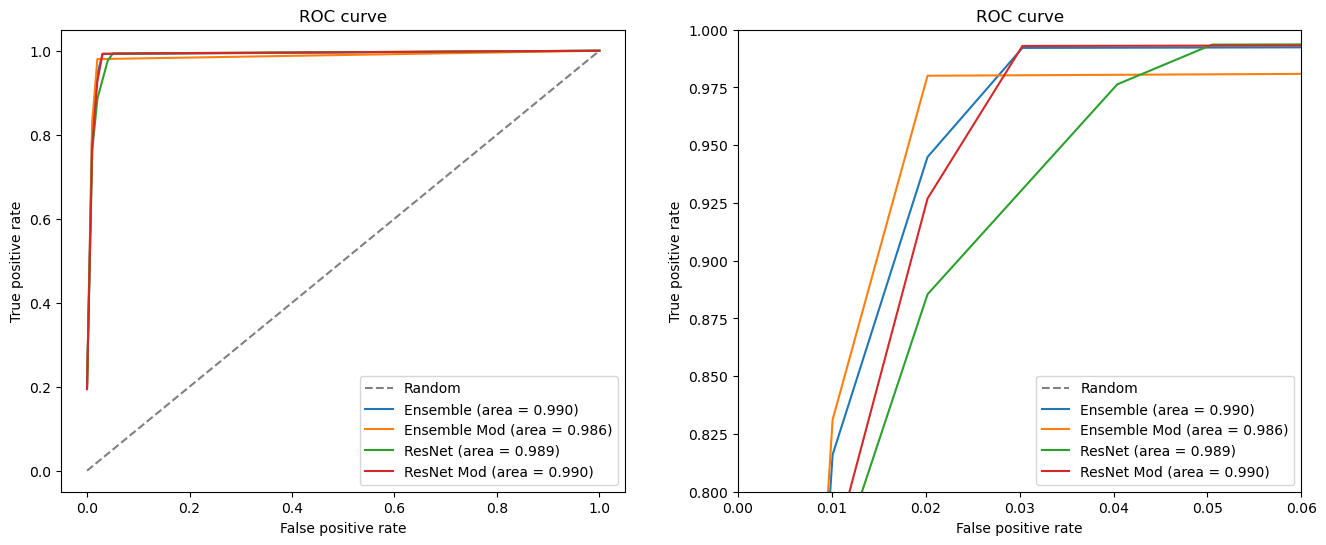

In [23]:
# Compare the 4 models using the receiver operating characteristic (ROC) curve
mean_tpr_ens = np.mean(mean_tpr_list_ens, axis=0)
mean_auc_ens = np.mean(auc_list_ens)

mean_tpr_ens_mod = np.mean(mean_tpr_list_ens_mod, axis=0)
mean_auc_ens_mod = np.mean(auc_list_ens_mod)

mean_tpr_res = np.mean(mean_tpr_list_res, axis=0)
mean_auc_res = np.mean(auc_list_res)

mean_tpr_res_mod = np.mean(mean_tpr_list_res_mod, axis=0)
mean_auc_res_mod = np.mean(auc_list_res_mod)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_ens, label='Ensemble (area = {:.3f})'.format(mean_auc_ens))
plt.plot(mean_fpr, mean_tpr_ens_mod, label='Ensemble Mod (area = {:.3f})'.format(mean_auc_ens_mod))
plt.plot(mean_fpr, mean_tpr_res, label='ResNet (area = {:.3f})'.format(mean_auc_res))
plt.plot(mean_fpr, mean_tpr_res_mod, label='ResNet Mod (area = {:.3f})'.format(mean_auc_res_mod))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

#Redo the above code but zoom in on the top left corner
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--', color='gray', label='Random')
plt.plot(mean_fpr, mean_tpr_ens, label='Ensemble (area = {:.3f})'.format(mean_auc_ens))
plt.plot(mean_fpr, mean_tpr_ens_mod, label='Ensemble Mod (area = {:.3f})'.format(mean_auc_ens_mod))
plt.plot(mean_fpr, mean_tpr_res, label='ResNet (area = {:.3f})'.format(mean_auc_res))
plt.plot(mean_fpr, mean_tpr_res_mod, label='ResNet Mod (area = {:.3f})'.format(mean_auc_res_mod))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.xlim(0, 0.06)
plt.ylim(0.8, 1)

The above plots show the ROC curve, with the right plot showing a zoomed in version to better show the differences between the models. Once again, our first Ensemble model is the best (with 0.99 AUC); interestingly, our Modified ResNet model also has an AUC of 0.99, suggesting that these two models may be more similiar than we think. It's also notable that the Modified Ensemble network once again performs the worst, with an AUC of only 0.986 (which, all things considered, isn't really that bad).

While the models' accuracies and ROC curves can help us compare the models, we still don't know if they're statistically different. Let's change that by performing some statistical tests.

In [24]:
t = 2.26 / np.sqrt(10)
e = (1 - np.mean(accuracies_ens)) - (1 - np.mean(accuracies_ens_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Ensemble Model and Modified Ensemble Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(accuracies_ens)) - (1 - np.mean(accuracies_res))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Ensemble Model and ResNet Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(accuracies_ens)) - (1 - np.mean(accuracies_res_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Ensemble Model and Modified ResNet Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(accuracies_ens_mod)) - (1 - np.mean(accuracies_res))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Ensemble Model and ResNet Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(accuracies_ens_mod)) - (1 - np.mean(accuracies_res_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Modified Ensemble Model and Modified ResNet Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

e = (1 - np.mean(accuracies_res)) - (1 - np.mean(accuracies_res_mod))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('ResNet Model and Modified ResNet Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)
#===================================================
print('\nEnsemble Model Accuracy:', np.mean(accuracies_ens))
print('Modified Ensemble Model Accuracy:', np.mean(accuracies_ens_mod))
print('ResNet Model Accuracy:', np.mean(accuracies_res))
print('Modified ResNet Model Accuracy:', np.mean(accuracies_res_mod))

Ensemble Model and Modified Ensemble Model Range: -0.004666674137115523 -0.004666674137115523
Ensemble Model and ResNet Model Range: -0.0009999990463257502 -0.0009999990463257502
Ensemble Model and Modified ResNet Model Range: -0.0006666660308838335 -0.0006666660308838335
Modified Ensemble Model and ResNet Model Range: 0.0036666750907897727 0.0036666750907897727
Modified Ensemble Model and Modified ResNet Model Range: 0.0040000081062316895 0.0040000081062316895
ResNet Model and Modified ResNet Model Range: 0.00033333301544191674 0.00033333301544191674

Ensemble Model Accuracy: 0.9903333425521851
Modified Ensemble Model Accuracy: 0.9856666684150696
ResNet Model Accuracy: 0.9893333435058593
Modified ResNet Model Accuracy: 0.9896666765213012


As we can see, none of the ranges obtained from comparing the models contain 0. Thus, we can say with 95% confidence that all of these models are statistically different from each other. That means that we can conclude that our best CNN is our original Ensemble Model.

### 2.4 Convolutional Network vs. Multi-Layer Perceptron

Now that we've created a few different CNN's, let's compare the best one (our original Ensemble Model) to a standard Multi-Layer Perceptron. First, let's create an MLP and then compare it to our Ensemble Model.

Fold 1


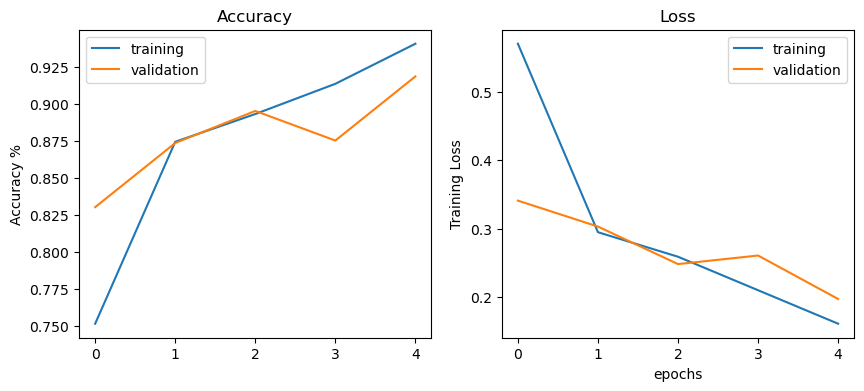

Fold 2


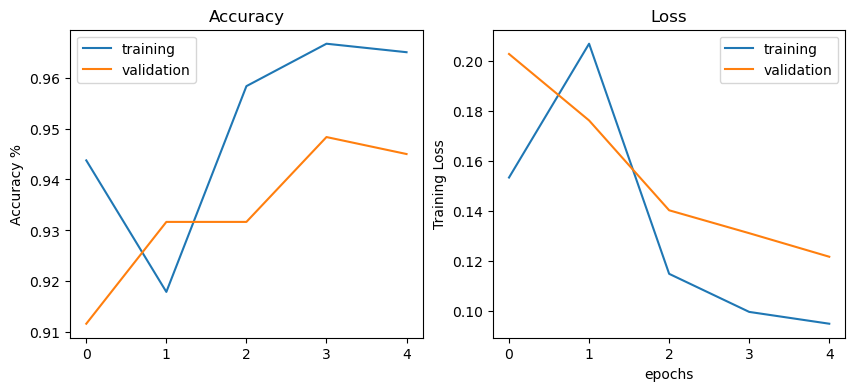

Fold 3


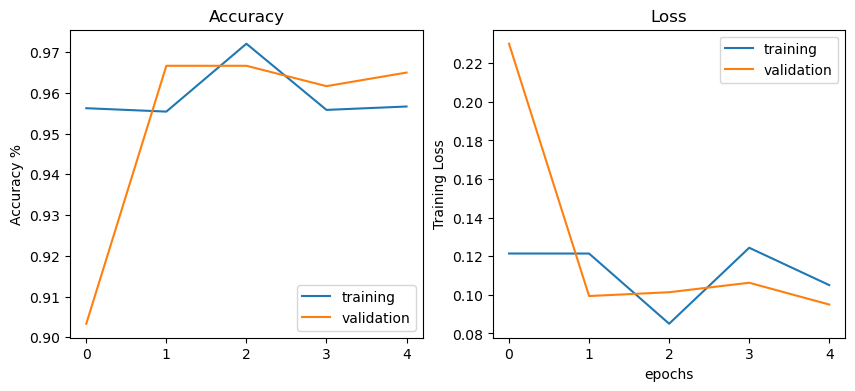

Fold 4


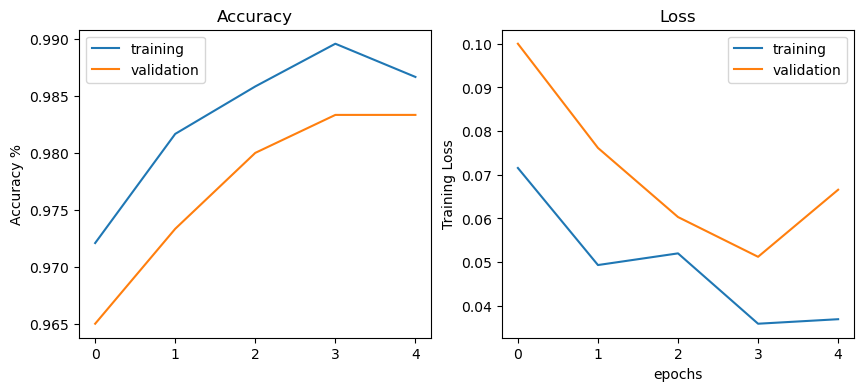

Fold 5


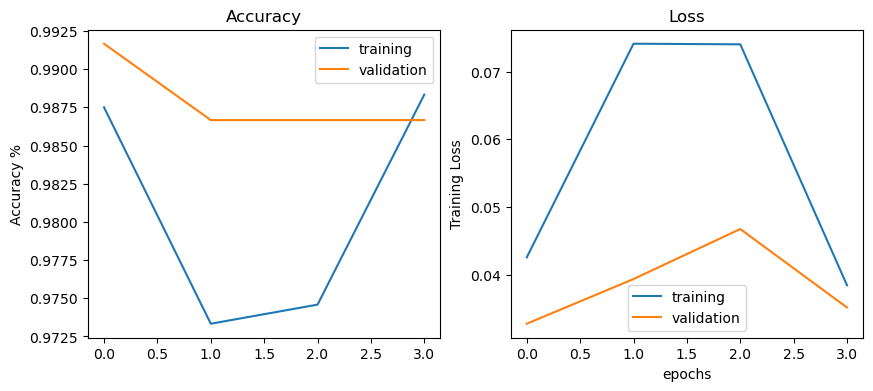

Average Accuracy: 0.9596666693687439


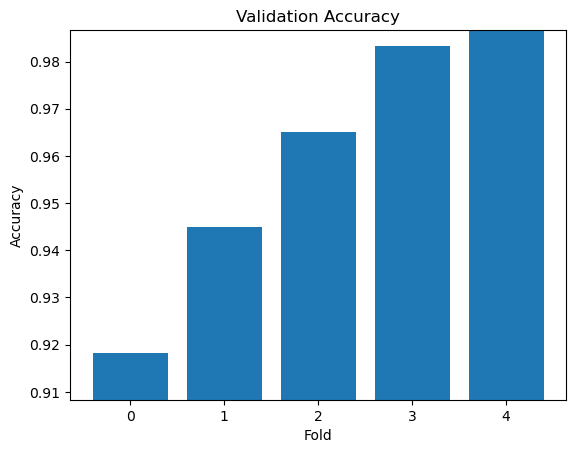

In [25]:
# Create a basic multi-layer perceptron model
from tensorflow.keras.layers import Activation

mlp = Sequential()
mlp.add(Flatten(input_shape=(img_wh,img_wh,3)))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1))
mlp.add(Activation('sigmoid'))

mlp.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

accuracies_mlp, mean_tpr_list_mlp, auc_list_mlp = get_accuracy(X, y, mlp)

As seen in the above graphs, the MLP's accuracy is frankly not on par with our Ensemble Model's accuracy (which is to be expected). It's also worth noting that the MLP has the highest variance across folds that we've seen so far (about 6.5%). It does appear to converge however, and its accuracy is respectable, so it's not completely worthless.

Now let's compare the MLP and the Ensemble Model by plotting their receiver operating characteristic (ROC) curves and calculating their area under the curve (AUC) values.

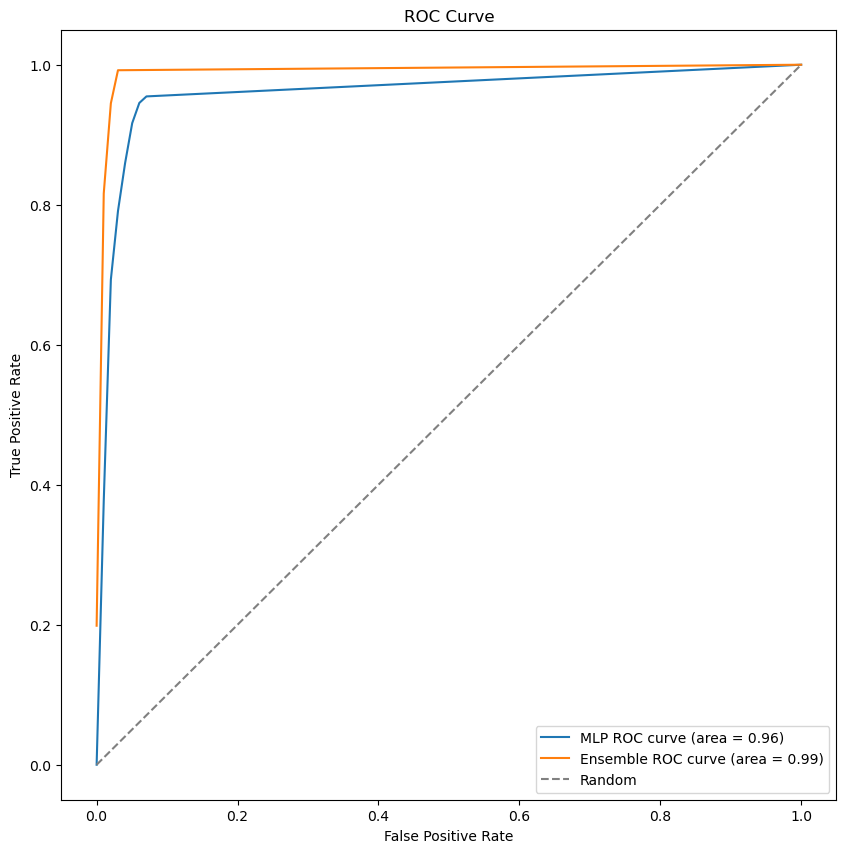

In [27]:
# Compare the Ensemble model to the MLP model using receiver operating characteristic (ROC) curves

# MLP model
mean_tpr_mlp = np.mean(mean_tpr_list_mlp, axis=0)
mean_auc_mlp = np.mean(auc_list_mlp)

# Ensemble model
mean_tpr_ens = np.mean(mean_tpr_list_ens, axis=0)
mean_auc_ens = np.mean(auc_list_ens)


# Plot ROC curves
plt.figure(figsize=(10,10))
plt.plot(mean_fpr, mean_tpr_mlp, label='MLP ROC curve (area = %0.2f)' % mean_auc_mlp)
plt.plot(mean_fpr, mean_tpr_ens, label='Ensemble ROC curve (area = %0.2f)' % mean_auc_ens)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

As seen above, the Ensemble Model has a higher AUC value than the MLP (0.99 vs. 0.96), suggesting that it is a better classifier than the MLP. This is not surprising, as the CNN's were able to achieve higher accuracy than the MLP, so it makes sense that they would also be better classifiers. Nevertheless, let's do a statistical test to see if the models are statistically different.

In [28]:
t = 2.26 / np.sqrt(10)
e = (1 - np.mean(accuracies_ens)) - (1 - np.mean(accuracies_mlp))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Ensemble Model and MLP Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

#===================================================
print('\nEnsemble Model Accuracy:', np.mean(accuracies_ens))
print('MLP Model Accuracy:', np.mean(accuracies_mlp))

Ensemble Model and MLP Model Range: -0.030666673183441184 -0.030666673183441184

Ensemble Model Accuracy: 0.9903333425521851
MLP Model Accuracy: 0.9596666693687439


As expected, the range from the statistical test doesn't contain 0. Therefore, we can say with 95% confidence that the two models are statistically different. Therefore, we can conclude that our Ensemble Model is better than a standard MLP for our classification task.

## 3. Transfer Learning
### 3.1 Transfer Learning Model
Now let's explore transfer learning models to see if we can get an even higher accuracy. We'll use a pre-trained model trained on imagenet to see if it's helpful in classifying our images as <code>vehicle</code> or <code>non-vehicle</code>. We'll also add a fully-connected layer to the end of the pre-trained model, and train only the end layers on our data (i.e., we won't re-train the layers from the pre-trained model, as that would frankly take too long).

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

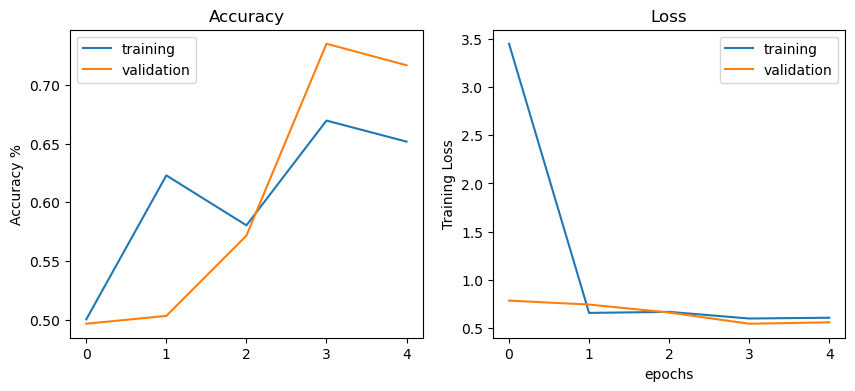

Fold 2


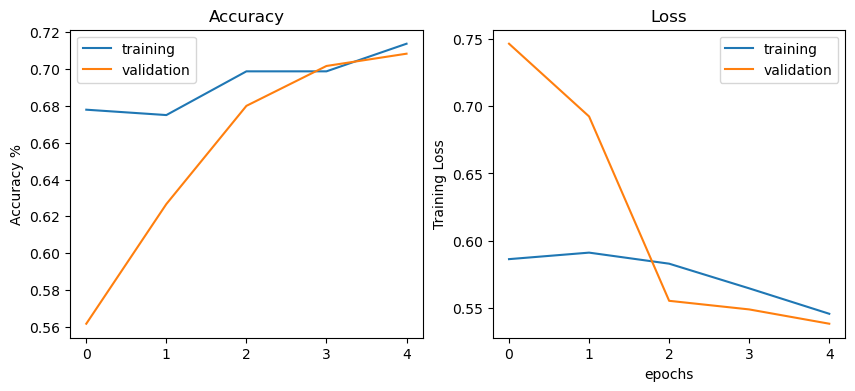

Fold 3


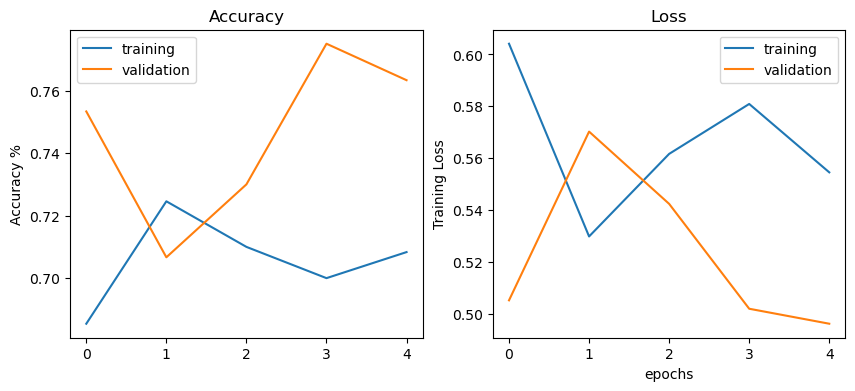

Fold 4


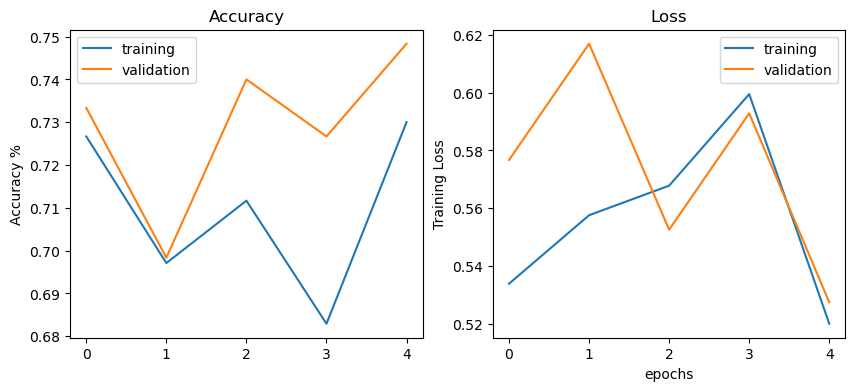

Fold 5


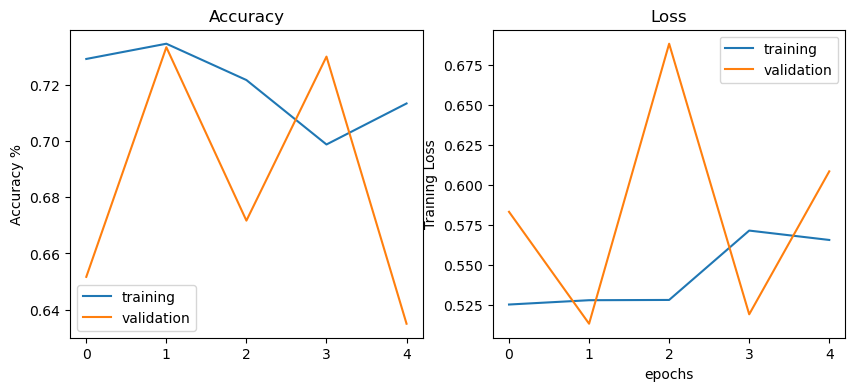

Average Accuracy: 0.7143333196640015


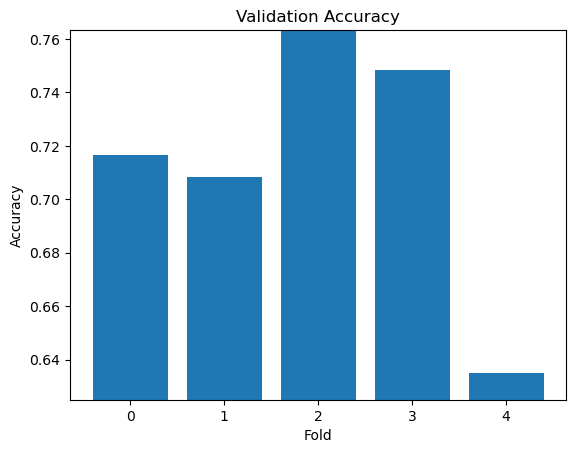

In [35]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.layers import SeparableConv2D

if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False, input_shape=(img_wh,img_wh,3))
    
for layer in res_no_top.layers:
    layer.trainable = False
    
# Adding a fully-connected layer
x = Flatten()(res_no_top.output)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)

predictions = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

res_transfer = clone_model(model_base)
res_transfer = Model(inputs=res_no_top.input, outputs=predictions)
res_transfer.summary()

res_transfer.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

accuracies_transfer, mean_tpr_list_transfer, auc_list_transfer = get_accuracy(X, y, res_transfer)

As seen above, our Transfer Learning Model's accuracy is only 71.4%, which isn't as good as any of our Convolutional Neural Networks. It also has a fairly high variance across all folds (around 12%), but it does generally seem to converge. 

Its poor performance (relative to our other CNN models) is likely due to the pre-trained layers being too generalized; we suspect that doing additional training on these layers with our data would improve performance (at least slightly). Unfortunately, due to computational and time constraints, we cannot explore this hypothesis further. Nevertheless, our Transfer Learning Model shows promise, and with some fine tuning, it could potentially perform as well as our other CNN models.

### 3.2 Model Comparison
Now let's compare the classification performance of our Transfer Learning Model to our Ensemble Model we created in the previous section.

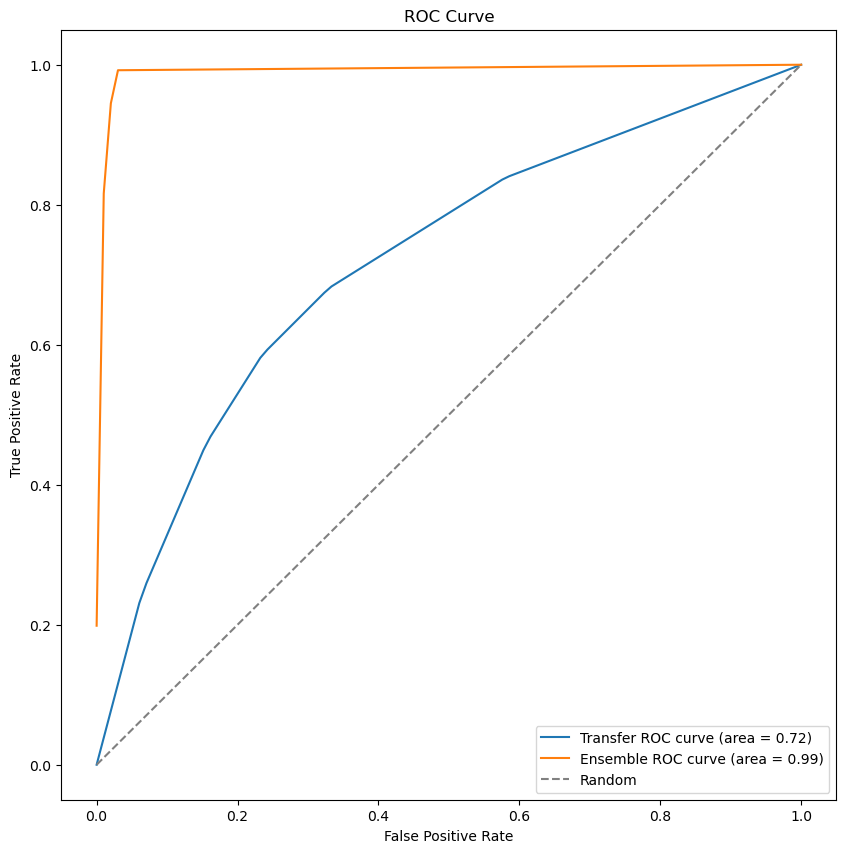

In [36]:
# Compare our best CNN model to the transfer learning model based on classification accuracy

# Transfer model
mean_tpr_transfer = np.mean(mean_tpr_list_transfer, axis=0)
mean_auc_transfer = np.mean(auc_list_transfer)

# Ensemble model
mean_tpr_ens = np.mean(mean_tpr_list_ens, axis=0)
mean_auc_ens = np.mean(auc_list_ens)


# Plot ROC curves
plt.figure(figsize=(10,10))
plt.plot(mean_fpr, mean_tpr_transfer, label='Transfer ROC curve (area = %0.2f)' % mean_auc_transfer)
plt.plot(mean_fpr, mean_tpr_ens, label='Ensemble ROC curve (area = %0.2f)' % mean_auc_ens)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

As seen above, the Ensemble Model has a much higher AUC value than the Transfer Model (0.99 vs. 0.72), which shows that it is a much better classifier than the Transfer Model. These AUC values also generally line up with each model's respective accuracy. To conclude, let's do a statistical test to see if the models are statistically different.

In [37]:
t = 2.26 / np.sqrt(10)
e = (1 - np.mean(accuracies_ens)) - (1 - np.mean(accuracies_transfer))
TotalSTD = np.std(e)
dbar = np.mean(e)
print('Ensemble Model and Transfer Model Range:', dbar-t*TotalSTD,dbar+t*TotalSTD)

#===================================================
print('\nEnsemble Model Accuracy:', np.mean(accuracies_ens))
print('Transfer Model Accuracy:', np.mean(accuracies_transfer))

Ensemble Model and Transfer Model Range: -0.2760000228881836 -0.2760000228881836

Ensemble Model Accuracy: 0.9903333425521851
Transfer Model Accuracy: 0.7143333196640015


As shown above, the range from the statistical test doesn't contain 0. Therefore, we can say with 95% confidence that these models are different, and we can conclude that our original Ensemble Model is the best Neural Network for our prediction task.

Thus, while Transfer Learning Models show promise, we would need to do more exploration to see if we can make one that can compete with our CNN Models.